# UV-Guider alignement with source in autocoll
##  Field 1

In [1]:
%matplotlib inline

from __future__ import division, print_function

import sys
sys.path.insert(1, './Calibration')
sys.path.append( '../../FireBallPipe')


import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table
import matplotlib.patches as patches

from guider2UV.guider2UV import Guider2UV, diff_skycoord

from Calibration.mapping import Mapping

In [2]:
cloudpath = '/home/dvibert/ownCloud/FIREBALL/'
cloudpath = '/Users/Vincent/Nextcloud/LAM/FIREBALL/'

path_SC_GUI02 = cloudpath + 'Tests-at-FortSumner/170909_SC_GUI02/'

#mask_plate_scale = 42.26134 #mm/deg

#detector platescale
#yscale = 1.106 # arcsec/pix spatial (y det -> y mask)
#xscale = 1.271 # arcsec/pix spectral (x det -> - x mask)

#guider center => put source on guider center
gc = np.array([640, 540])

## calibrated frame encoder gains:

EL : 0.092 x 1.00379 = 0.09469 arcsec/inc

CE : 0.01 x 1.02928 = 0.010293 arcsec/inc

In [3]:
# encoder gains:

CEg = 1.02928
Elg = 1.00379

# 2018 calibrated gains put in CNES software
#CEg = 1.0
#Elg = 1.0

## initialization from last xy calib

In [4]:
G2UV = Guider2UV(filename=path_SC_GUI02 + 'Guider2UV_F1_nogamma.new.pkl')
gc_coord = G2UV.GuiderP.pix2local([gc])

target_filename =  '../Calibration/Targets/targets_F1.txt'
F1 = Table.read(target_filename, format='ascii')

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    (0.17639951, 0.0154012)>
FOV center pixel position in guider [array(1338.56657245), array(600.7867847)]


load current mapping

In [5]:
diffuse_tab_file = '/data/FireBall/FTS-06-2018/180612/image-000275-000284-Zinc-with_dark119-stack_table.csv'
# diffuse_path = cloudpath+'TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/DiffuseMasksIllumination180823/'
# diffuse_tab_file = diffuse_path + 'StackedImage_44-63-NoDark_table.csv'
diffuse_tab = Table.read(diffuse_tab_file, format='csv')
mask_det_map_file = '/home/dvibert/work/FireBallPipe/mapping-mask-det-180823-F1.pkl'
mask_det_map_file = '/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/Detector_Mask_mappings/mapping-mask-det-180823-F1.pkl'


mask_det_map = Mapping(mask_det_map_file)
dxm_dyd = -0.013
dym_dxd = -0.015
m = np.array([[0., dxm_dyd],[dym_dxd ,0.]])

FileNotFoundError: [Errno 2] No such file or directory: '/data/FireBall/FTS-06-2018/180612/image-000275-000284-Zinc-with_dark119-stack_table.csv'

## Diffuse UV image

load new mapping

In [46]:
diffuse_path = '/data/ownCloud/FIREBALL/TestsFTS2018-Flight/AIT-Optical-FTS-2018-Flight/XYCalibration/DiffuseMasksIllumination180823/'
diffuse_path = '/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/DiffuseMasksIllumination180823/'
diffuse_tab_file = diffuse_path + 'StackedImage_24-43-NoDark_table.csv'
diffuse_tab = Table.read(diffuse_tab_file, format='csv')
mask_det_map_file = '/home/dvibert/work/FireBallPipe/mapping-mask-det-180823-F1.pkl'
mask_det_map_file = '/Users/Vincent/Nextcloud/LAM/FIREBALL/TestsFTS2018-Flight/E2E-AIT-Flight/XYCalibration/Detector_Mask_mappings/mapping-mask-det-180823-F1.pkl'
mask_det_map = Mapping(mask_det_map_file)
dxm_dyd = -0.013
dym_dxd = -0.015
m = np.array([[0., dxm_dyd],[dym_dxd ,0.]])

record shift from mapping

positive: current diffuse -> mapping (old diffuse)

In [14]:
diffuse_offset = [ 14.6+1, 0.+1] 
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## Scan sequence

gc - 46 - 51 -FHC- 4 - FHC - 8 - gc - new model - FHC - 12 - s8 - s31 - FHC - s25 - gc

### Go from guider to 1st slit: #46

In [15]:
slit_pos1 =   np.array([F1[F1['Internal-count']=='46']['xmm'][0], F1[F1['Internal-count']=='46']['ymm'][0]])

print("slit position in mm on mask:", slit_pos1)
slit_coord1 = G2UV.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#frame move
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit coord in guider local frame: ['0d05m20.08964178s -0d08m48.87471519s']
EL: [159.44054124] arcsec 
CE: [256.91488963] arcsec


### Go from guider to 1st slit: #46

In [16]:
slit_pos1 =   np.array([F1[F1['Internal-count']=='46']['xmm'][0], F1[F1['Internal-count']=='46']['ymm'][0]])

print("slit position in mm on mask:", slit_pos1)
slit_coord1 = G2UV.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#frame move
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit coord in guider local frame: ['0d05m20.08964178s -0d08m48.87471519s']
EL: [159.44054124] arcsec 
CE: [256.91488963] arcsec


remove offset from model to prediction

In [17]:
slit_coord1_det = direct_map(mask_det_map.w[1], slit_pos1[0], slit_pos1[1])
print("mapped slit position on detector: ", slit_coord1_det)

mapped slit position on detector:  [1801.96825511  420.67108983]


In [18]:
# compute observed position on mask
slit_coord1_obs_det = np.array([1796.9, 454.6]) # observed
slit_coord1_obs_wave = 0.20619
slit_pos1_obs = inv_map(slit_coord1_obs_wave, slit_coord1_obs_det[0], slit_coord1_obs_det[1])
slit_pos1_obs2 = slit_pos1 + m.dot(slit_coord1_obs_det - slit_coord1_det)
print("observed slit position in mm on mask:", slit_pos1_obs)
print("observed slit position (linear mapping) in mm on mask:", slit_pos1_obs2)

slit_coord1_obs = G2UV.SienceMask2guider(slit_pos1_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord1_obs.to_string(u'dms'))
slit_coord1_obs_pix = G2UV.SienceMask2guider(slit_pos1_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord1_obs_pix)


observed slit position in mm on mask: [ 6.32991818 -3.76309197]
observed slit position (linear mapping) in mm on mask: [ 6.31788027 -3.78295517]
observed slit coord in guider local frame: ['0d05m27.40105344s -0d08m12.04208206s']
observed slit coord in guider pixel frame: [array([1011.27778316]), array([-2.53131635])]


In [19]:
offset =  diff_skycoord(slit_coord1_obs, slit_coord1) 
print("offset from guider in arcsec (guider frame): \n",offset*3600)


offset from guider in arcsec (guider frame): 
 [[ -7.31141166]
 [-36.83263313]]


In [20]:
G2UVnew  = G2UV.copy()

newFOVcenter = coordinates.SkyCoord(G2UV.FOV_center_guider_coord.lon + offset[0]*u.deg, 
                              G2UV.FOV_center_guider_coord.lat + offset[1]*u.deg,
                              frame = G2UV.GuiderP.localframe)
                     
G2UVnew.FOV_center_guider_coord = newFOVcenter

In [21]:
slit_coord1_cor = G2UVnew.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame, corrected from offset:", slit_coord1_cor.to_string(u'dms'))


slit coord in guider local frame, corrected from offset: ['0d05m12.77823011s -0d09m25.70734833s']


### go back to guider center (absolute)

go to 1st slit, offset removed:

In [22]:

slit_coord1 = G2UVnew.SienceMask2guider(slit_pos1, angle=True)
print("slit coord in guider local frame:", slit_coord1.to_string(u'dms'))

#frame move
theta_EL =  slit_coord1.lon.deg/2./Elg
theta_CE = -slit_coord1.lat.deg/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit coord in guider local frame: ['0d05m12.77823011s -0d09m25.70734833s']
EL: [155.79863822] arcsec 
CE: [274.80731595] arcsec


### Loop on slits

In [23]:
slits = ['46', '51', '14', '8'] 
slits += slits[::-1]
slits

['46', '51', '14', '8', '8', '14', '51', '46']

In [24]:
slit_pos = np.zeros((len(slits),2))
slit_coord = []
slit_coord_pix = np.zeros((len(slits),2))
theta_EL = np.zeros(len(slits))
theta_CE = np.zeros(len(slits))

for i, s in enumerate(slits):
    
    slit_pos[i] = np.array([F1[F1['Internal-count']==s]['xmm'][0], F1[F1['Internal-count']==s]['ymm'][0]])
    print("slit position in mm on mask:", slit_pos[i])
    slit_coord.append(G2UVnew.SienceMask2guider(slit_pos[i], angle=True))
    print("slit coord in guider local frame:", slit_coord[-1].to_string(u'dms'))
    slit_coord_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos[i], angle=False)).T
    print("slit coord in guider pixel frame:", slit_coord_pix[i])

    #frame move
    theta_EL[i] =  slit_coord[-1].lon.deg/2./Elg
    theta_CE[i] = -slit_coord[-1].lat.deg/2./CEg
    print("EL: {:.1f} arcsec \nCE: {:.1f} arcsec".format(theta_EL[i]*3600, theta_CE[i]*3600))
    
# compute relative moves
moves_EL = theta_EL[1:] - theta_EL[:-1]
moves_CE = theta_CE[1:] - theta_CE[:-1]


slit position in mm on mask: [ 6.7589561 -3.858979 ]
slit coord in guider local frame: ['0d05m12.77823011s -0d09m25.70734833s']
slit coord in guider pixel frame: [997.367659   -84.38746204]
EL: 155.8 arcsec 
CE: 274.8 arcsec
slit position in mm on mask: [8.6160157 1.0303866]
slit coord in guider local frame: ['0d12m13.54645334s -0d11m54.02396477s']
slit coord in guider pixel frame: [1455.13566132 -227.07193216]
EL: 365.4 arcsec 
CE: 346.9 arcsec
slit position in mm on mask: [-5.1696728  3.934102 ]
slit coord in guider local frame: ['0d15m52.30054829s 0d07m47.4574636s']
slit coord in guider pixel frame: [1679.91043411 1037.48087294]
EL: 474.4 arcsec 
CE: -227.1 arcsec
slit position in mm on mask: [-8.8972191 -0.6960435]
slit coord in guider local frame: ['0d09m09.82941413s 0d12m55.97457687s']
slit coord in guider pixel frame: [1264.03668502 1382.56643118]
EL: 273.9 arcsec 
CE: -377.0 arcsec
slit position in mm on mask: [-8.8972191 -0.6960435]
slit coord in guider local frame: ['0d09m09.

In [25]:
# remove middle
idx = np.arange(len(slits)//2)
idx = np.concatenate((idx[:-1], idx[:-1]+len(idx)))
for i in idx:
    print("move:  EL {:.1f} arcsec - CE {:.1f} arcsec".format(moves_EL[i]*3600, moves_CE[i]*3600))


move:  EL 209.6 arcsec - CE 72.0 arcsec
move:  EL 109.0 arcsec - CE -573.9 arcsec
move:  EL -200.5 arcsec - CE -149.9 arcsec
move:  EL 200.5 arcsec - CE 149.9 arcsec
move:  EL -109.0 arcsec - CE 573.9 arcsec
move:  EL -209.6 arcsec - CE -72.0 arcsec


observed slits position :

In [26]:
#slit_coord_obs_det = np.zeros((8,2)) + np.array([1800, 421])

slit_coord_obs_det = np.array([[ 1803 ,  421.2 ],
         [ 1469.6 ,  288.7 ],
         [ 1304.2 , 1347.9 ],
         [ 1619.6 ,  1625.4 ],
         [ 1620 ,  1626.6 ],

         [ 1304.3 ,  1355.6 ],
         [ 1469.5 ,  288.7 ],
         [ 1802.9 ,  412.5 ]])
slit_coord_obs_det

array([[1803. ,  421.2],
       [1469.6,  288.7],
       [1304.2, 1347.9],
       [1619.6, 1625.4],
       [1620. , 1626.6],
       [1304.3, 1355.6],
       [1469.5,  288.7],
       [1802.9,  412.5]])

In [27]:
mask_det_map.map(mask_det_map.w[1], slit_pos[:,0], slit_pos[:, 1]).T + diffuse_offset
#direct_map(mask_det_map.w[1], slit_pos[:,0].T, slit_pos[:, 1].T)

array([[1801.96825511,  420.67108983],
       [1469.29514119,  286.56101201],
       [1295.35176435, 1349.1566357 ],
       [1608.56048921, 1627.87990416],
       [1608.56048921, 1627.87990416],
       [1295.35176435, 1349.1566357 ],
       [1469.29514119,  286.56101201],
       [1801.96825511,  420.67108983]])

map on mask :

In [28]:
slit_coord_obs_wave = 0.20619    

#slit_pos_obs = mask_det_map.inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T
slit_pos_obs = inv_map(slit_coord_obs_wave, slit_coord_obs_det[:,0], slit_coord_obs_det[:,1]).T
#print(slit_pos_obs - slit_pos)

#print(slit_coord_obs_wave)
#print(slit_pos_obs)


In [29]:
slit_coord_obs = []
slit_coord_obs_pix = np.zeros((len(slits),2))

for i, s in enumerate(slits):
    
    print("observed slit position in mm on mask:", slit_pos_obs[i])
    slit_coord_obs.append(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=True))
    print("observed slit coord in guider local frame:", slit_coord_obs[-1].to_string(u'dms'))
    slit_coord_obs_pix[i] = np.array(G2UVnew.SienceMask2guider(slit_pos_obs[i], angle=False)).T
    print("observed slit coord in guider pixel frame:", slit_coord_obs_pix[i])



observed slit position in mm on mask: [ 6.76495747 -3.86941027]
observed slit coord in guider local frame: ['0d05m11.90056827s -0d09m26.24218471s']
observed slit coord in guider pixel frame: [996.42184926 -85.0139446 ]
observed slit position in mm on mask: [8.5901649  1.01562411]
observed slit coord in guider local frame: ['0d12m12.23289954s -0d11m51.84491409s']
observed slit coord in guider pixel frame: [1453.67151893 -224.79215479]
observed slit position in mm on mask: [-5.14382363  3.8054746 ]
observed slit coord in guider local frame: ['0d15m41.38440288s 0d07m44.97784164s']
observed slit coord in guider pixel frame: [1668.46178891 1035.12928845]
observed slit position in mm on mask: [-8.84456363 -0.85730731]
observed slit coord in guider local frame: ['0d08m56.18641599s 0d12m51.14009762s']
observed slit coord in guider pixel frame: [1249.14181189 1378.00583341]
observed slit position in mm on mask: [-8.86021446 -0.86324882]
observed slit coord in guider local frame: ['0d08m55.64668

## compute NEW MODEL: orientation, offset & magnification

In [30]:
slit_coord_F = np.zeros((len(slits),2))
slit_coord_obs_F = np.zeros((len(slits),2))

for i in range(len(slits)):
    
    c = G2UVnew.guider_to_FieldLocal(slit_coord[i], angle=True)
    slit_coord_F[i] = np.array([ c.lon.deg, c.lat.deg]).T
    
    c_obs = G2UVnew.guider_to_FieldLocal(slit_coord_obs[i], angle=True)
    slit_coord_obs_F[i] = np.array([ c_obs.lon.deg, c_obs.lat.deg]).T

    
delta = slit_coord_obs_F - slit_coord_F
print(delta*3600)


[[ -0.89072541  -0.51339919]
 [ -1.26032974   2.21113468]
 [-10.97671104  -2.21299134]
 [-13.76108196  -4.50124432]
 [-14.26842836  -3.16238917]
 [-10.99422512   6.29041816]
 [ -1.13312113   2.21103239]
 [ -1.09740917 -10.1148133 ]]


In [31]:
row_x = np.hstack((slit_coord_F*[1.,-1], np.ones((8,1)), np.zeros((8,1)) )) # xn -x = x dgamma - y theta + dx
row_y = np.hstack((slit_coord_F[:,::-1], np.zeros((8,1)), np.ones((8,1)) )) # yn - y = x theta - y dgamma 
mat = np.vstack((row_x, row_y))
matinv =  np.linalg.pinv(mat)
data = np.concatenate((delta[:,0], delta[:,1]))
sol = matinv.dot(data)
gama = 1 + sol[0]
theta_rad = sol[1]
deltax = sol[2]
deltay = sol[3]
theta = theta_rad*180/np.pi*60 #arcmin
print("gamma: {}\ntheta: {} arcmin\ndx: {} arcsec\ndy: {} arcsec".format(gama, theta, deltax*3600, deltay*3600))
covar = matinv.dot(matinv.T)
# accuracy, assuming 1 arcsec measurement error
print("variances: {}\n".format(np.sqrt(np.diag(covar))/3600*[1, 180/np.pi*60, 3600, 3600])) #
#residual
data_new = mat.dot(sol) 
print("residuals in arcsec:", (data_new - data)*3600)

gamma: 0.9983429715031369
theta: 32.4708570269681 arcmin
dx: -7.046995563730491 arcsec
dy: -1.352563741666009 arcsec
variances: [5.16707991e-04 1.77631123e+00 3.53876134e-01 3.53876134e-01]

residuals in arcsec: [-0.16428207  1.01208255 -0.79092073 -0.35904758  0.14829883 -0.77340664
  0.88487394  0.0424017  -2.99329676 -1.51493375  3.29909115  1.32951349
 -0.00934166 -5.20431836 -1.51483146  6.60811735]


Text(-10, 7, 'rotation: 32.47 arcmin\nmagnification 0.9983\ndeltax: 1.3526 arcsec\ndeltay: -7.0470 arcsec')

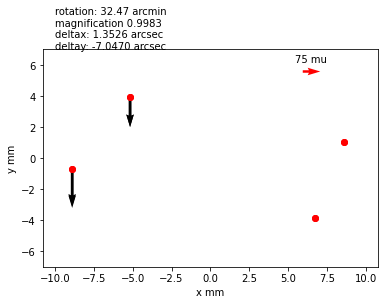

In [32]:
mask_plate_scale = 42.26134
plt.figure()
plt.axis('equal')
plt.plot(slit_pos[:,0], slit_pos[:,1], 'or')
qv = plt.quiver(slit_pos[:,0], slit_pos[:,1], 0., delta[:,0]*mask_plate_scale)
plt.quiverkey(qv, .8,.9,.075, "75 mu", color='r')
plt.xlim([-13, 13])
plt.ylim([-7,7])
plt.xlabel('x mm')
plt.ylabel('y mm')
plt.text(-10,7,"rotation: {:.2f} arcmin\nmagnification {:.4f}\ndeltax: {:.4f} arcsec\ndeltay: {:.4f} arcsec".format(theta, gama, -deltay*3600, deltax*3600))



In [33]:
sit_pos14_obs_det = np.array([1312.8, 1357.7])
slit_pos14_obs = inv_map(slit_coord_obs_wave, sit_pos14_obs_det[0], sit_pos14_obs_det[1]).T
print(slit_pos14_obs, slit_pos[2])

print(G2UV.FieldP.pix2local(slit_pos[2]))
print(G2UV.FieldP.pix2local(slit_pos14_obs))

[-5.27348666  3.67916712] [-5.1696728  3.934102 ]
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>): (lon, lat) in deg
    (0.09314914, 0.12240419)>
<SkyCoord (SkyOffsetICRS: rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (32.19, -5.688)>): (lon, lat) in deg
    (0.08711183, 0.12486061)>


In [34]:
direct_map(slit_coord_obs_wave, slit_pos[2,0], slit_pos[2,1])

array([1295.35176435, 1349.1566357 ])

In [35]:
G2UVcor  = Guider2UV(guider_wcs=G2UVnew.GuiderP.w, 
                     Field_center=G2UVnew.FieldP.center, 
                     Field_rotation=G2UVnew.FieldP.rotation,
                     Field_gamma=gama,
                     mask_rotation=G2UVnew.mask_rotation + theta*u.arcmin)


#deltaFOV = - 1/gama*deltax

#G2UVnew  = Guider2UV(guider_wcs=G2UV.GuiderP.w, 
#                     Field_center=G2UV.FieldP.center, 
#                     Field_rotation=G2UV.FieldP.rotation,
#                     Field_gamma=gama)
#                     #mask_rotation=theta*u.arcmin)
#
#deltaFOV = - deltax

newFOVcenter = coordinates.SkyCoord(G2UVnew.FOV_center_guider_coord.lon + deltax*u.deg, 
                              G2UVnew.FOV_center_guider_coord.lat + deltay*u.deg,
                              frame = G2UVnew.GuiderP.localframe)
                     
G2UVcor.FOV_center_guider_coord = newFOVcenter

#G2UVnew.FOV_guider_coord = G2UV.FOV_guider_coord


## check new model on new slit #21

start from last slit #46

In [36]:
slitcheck = '21'
slit_pos5 =   np.array([F1[F1['Internal-count']==slitcheck]['xmm'][0], F1[F1['Internal-count']==slitcheck]['ymm'][0]])

print("slit position in mm on mask:", slit_pos5)
slit_coord5 = G2UVcor.SienceMask2guider(slit_pos5, angle=True)
print("slit coord in guider local frame:", slit_coord5.to_string(u'dms'))
slit_coord5_pix = G2UVcor.SienceMask2guider(slit_pos5, angle=False)
print("slit coord in guider pixel frame:", slit_coord5_pix)

#frame move
theta_EL =  (slit_coord5.lon.deg -  slit_coord[0].lon.deg)/2./Elg
theta_CE = -(slit_coord5.lat.deg -  slit_coord[0].lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [-2.4108349  4.2733935]
slit coord in guider local frame: ['0d16m17.28773876s 0d03m54.6724083s']
slit coord in guider pixel frame: [array([1701.38526186]), array([790.49196444])]
EL: [331.00026333] arcsec 
CE: [-388.80564891] arcsec


## check new model on known slit #14

start from last slit #14

In [37]:
slits

['46', '51', '14', '8', '8', '14', '51', '46']

In [38]:
slitcheck2 = slits[2]
slit_pos6 =   np.array([F1[F1['Internal-count']==slitcheck2]['xmm'][0], F1[F1['Internal-count']==slitcheck2]['ymm'][0]])

print("slit position in mm on mask:", slit_pos6)
slit_coord6 = G2UVcor.SienceMask2guider(slit_pos6, angle=True)
print("slit coord in guider local frame:", slit_coord6.to_string(u'dms'))
slit_coord6_pix = G2UVcor.SienceMask2guider(slit_pos6, angle=False)
print("slit coord in guider pixel frame:", slit_coord6_pix)

#frame move
theta_EL =  (slit_coord6.lon.deg -  slit_coord5.lon.deg)/2./Elg
theta_CE = -(slit_coord6.lat.deg -  slit_coord5.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

slit position in mm on mask: [-5.1696728  3.934102 ]
slit coord in guider local frame: ['0d15m40.56046284s 0d07m48.52328867s']
slit coord in guider pixel frame: [array([1667.69160409]), array([1038.90746244])]
EL: [-18.29430256] arcsec 
CE: [-113.59925402] arcsec


compared observed vs diffuse

| wavelength | diffuse   | observed |
|------------|-----------|----------|
| 0.21382    |           |           
| 0.20619    | 1738.31531.2| 1754.3x1574.3
| 0.20255    |   |


In [39]:
# compute observed position on mask
slit_coord5_obs_det = np.array([1754.3, 1574.3])
slit_coord5_obs_wave = 0.20619
slit_pos5_obs = mask_det_map.inv_map(slit_coord5_obs_wave, slit_coord5_obs_det[0], slit_coord5_obs_det[1])
print("observed slit position in mm on mask:", slit_pos5_obs)
slit_coord5_obs = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=True)
print("observed slit coord in guider local frame:", slit_coord5_obs.to_string(u'dms'))
slit_coord5_obs_pix = G2UVnew.SienceMask2guider(slit_pos5_obs, angle=False)
print("observed slit coord in guider pixel frame:", slit_coord5_obs_pix)


observed slit position in mm on mask: [-8.24646907 -3.11000349]
observed slit coord in guider local frame: ['0d05m45.31513902s 0d11m55.42508506s']
observed slit coord in guider pixel frame: [array([1039.4844154]), array([1326.59693706])]


## Guide stars

In [40]:
star_target_path = cloudpath + 'Target_selection/GuidingStars/'
F1_stars = Table.read(star_target_path + "F1_guidingstars.fits", format='fits')
F1_stars_coords = coordinates.SkyCoord(F1_stars['RA']*u.deg, F1_stars['DEC']*u.deg)


### star s8

In [41]:
star_pos1_radec = F1_stars_coords[F1_stars['Internal count']==8]
print("star position Ra/Dec: ", star_pos1_radec)
star_coord1 = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord1)
star_coord1_pix = G2UVnew.SienceMask2guider(star_pos1_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord1_pix)

#frame move
#theta_EL =  (star_coord1.lon.deg - slit_coord5_obs.lon.deg)/2./Elg
#theta_CE = -(star_coord1.lat.deg - slit_coord5_obs.lat.deg)/2./CEg
theta_EL =  (star_coord1.lon.deg)/2./Elg
theta_CE = -(star_coord1.lat.deg)/2./CEg

print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.1014, -5.786504)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    [(0.07370463, 0.09091228)]>
Star position in guider pixel frame:  [array([939.85059787]), array([902.18021436])]
EL: [132.16741631] arcsec 
CE: [-158.98697205] arcsec


observed star position: 960.2 x 892.8

### star s31

In [42]:
star_pos2_radec = F1_stars_coords[F1_stars['Internal count']==31]
print("star position Ra/Dec: ", star_pos2_radec)
star_coord2 = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord2)
star_coord2_pix = G2UVnew.SienceMask2guider(star_pos2_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord2_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord2.lon.deg - star_coord1.lon.deg)/2./Elg
theta_CE = -(star_coord2.lat.deg - star_coord1.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.254526, -5.815258)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    [(0.04867485, -0.06213244)]>
Star position in guider pixel frame:  [array([838.00214142]), array([290.94593573])]
EL: [-44.88348406] arcsec 
CE: [267.64388085] arcsec


observed star position: 860.2 x 287

### Frame Hysteresis Compensation in guider

In [43]:
# 1st try: go away and back to star 31
star_pos = np.array([846,318])
end_pos = np.array([850, 322]) # to be read on guider
# effective frame_move
theta_EL = 10. # in arcsec
theta_CE = -10. # in arcsec
scale = (end_pos - star_pos)/np.array([theta_EL, theta_CE]) 

# compute final frame move
theta = (np.array([star_coord2_pix[0] - end_pos[0], star_coord2_pix[1] - end_pos[1]]))/scale 
print("EL: {} arcsec \nCE: {} arcsec".format(theta[0], theta[1]))

EL: [-29.99464644  29.99464644] arcsec 
CE: [-77.63516067  77.63516067] arcsec


### star s25

In [44]:
star_pos3_radec = F1_stars_coords[F1_stars['Internal count']==25]
print("star position Ra/Dec: ", star_pos3_radec)
star_coord3 = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=True)
print("Star position in guider local frame: ", star_coord3)
star_coord3_pix = G2UVnew.SienceMask2guider(star_pos3_radec, world=True, angle=False)
print("Star position in guider pixel frame: ", star_coord3_pix)

#frame move
#theta_EL =  star_coord2.lon.deg/2./Elg
#theta_CE = -star_coord2.lat.deg/2./CEg
#print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

theta_EL =  (star_coord3.lon.deg - star_coord2.lon.deg)/2./Elg
theta_CE = -(star_coord3.lat.deg - star_coord2.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

star position Ra/Dec:  <SkyCoord (ICRS): (ra, dec) in deg
    [(32.221491, -5.776507)]>
Star position in guider local frame:  <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39272815, 36.41856381)>): (lon, lat) in deg
    [(0.08662596, -0.02832302)]>
Star position in guider pixel frame:  [array([988.05525116]), array([427.65446673])]
EL: [68.05407238] arcsec 
CE: [-59.1257503] arcsec


observed star position 1007.6 x  417

### back to guider center

In [45]:
#frame move
theta_EL =  (0. - star_coord3.lon.deg)/2./Elg
theta_CE = -(0. - star_coord3.lat.deg)/2./CEg
print("EL: {} arcsec \nCE: {} arcsec".format(theta_EL*3600, theta_CE*3600))

EL: [-155.33800463] arcsec 
CE: [-49.53115851] arcsec
